In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization


plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
normalize = True
data_size = 10**6
n_moments = 2
mylambda = []

In [3]:
moment = 2
obs = 'q'

In [4]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = np.load('npfiles/rawdata.npz')
pT_true, pT_true_alt, pT_reco, pT_reco_alt, m_true, m_true_alt, m_reco, m_reco_alt, q_true, q_true_alt, q_reco, q_reco_alt = (datasets[datasets.files[i]] for i in range(12))

In [5]:
x_gen = q_true_alt #gen = particle level
x_sim = q_reco_alt #sim = detector level
x_truth = q_true
x_data = q_reco

p_gen = pT_true_alt #gen = particle level
p_sim = pT_reco_alt #sim = detector level
p_truth = pT_true
p_data = pT_reco


if normalize:   
    xm = np.mean(x_truth)
    xs = np.std(x_truth)
    pm = np.mean(p_truth)
    ps = np.mean(p_truth)
    
    x_gen = (x_gen - xm)/xs
    x_sim = (x_sim - xm)/xs
    x_truth = (x_truth - xm)/xs
    x_data = (x_data - xm)/xs
    
    p_gen = (p_gen - pm)/ps
    p_sim = (p_sim - pm)/ps
    p_truth = (p_truth - pm)/ps
    p_data = (p_data - pm)/ps

In [6]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.m0 = self.add_weight(name='m0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.m1 = self.add_weight(name='m1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v0 = self.add_weight(name='v0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v1 = self.add_weight(name='v1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y = tf.exp((self.m0 + self.m1*x[:, 0]) * x[:,1] + (self.v0 + self.v1*x[:,0]) * x[:,1]**2)
        return tf.reshape(y, (len(x), 1))

In [7]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [8]:
initial_learning_rate = 5e-3
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True)

In [9]:
myc = 0.1


mymodel_inputtest = Input(shape=(2,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((2, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimintor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimintor.compile(loss=weighted_binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    
model_discrimintor.trainable = False
mymodel_gan = Input(shape=(2,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimintor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

2023-12-26 22:08:43.405120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 22:08:43.964236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78943 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [10]:
xvals_particle = np.transpose([np.concatenate([x_gen,x_truth]), np.concatenate([p_gen,p_truth])])
xvals_detector = np.transpose([np.concatenate([x_sim,x_data]), np.concatenate([p_sim,p_data])])                        
yvals = np.transpose(np.concatenate([np.ones(len(x_gen)),np.zeros(len(x_truth))]))

X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals)

In [11]:
n_epochs = 5
n_batch = 128*10
n_batches = len(X_train_particle) // n_batch

for i in range(n_epochs):
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch_particle = X_train_particle[j*n_batch:(j+1)*n_batch]
        X_batch_detector = X_train_detector[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==1] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimintor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],Y_batch[Y_batch==0])
    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=", i, mylambda.T)

2023-12-26 22:08:45.805416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-26 22:08:46.492663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


on epoch= 0 [[-0.00264255  0.0552332  -0.03648504 -0.08845901]]
on epoch= 1 [[ 0.01840349  0.06780055 -0.06246533 -0.09221158]]
on epoch= 2 [[ 0.07329761  0.00401548 -0.10909399  0.00052194]]
on epoch= 3 [[-0.01143353  0.0186755   0.00483435 -0.04422048]]
on epoch= 4 [[ 0.01410482  0.00825012 -0.0219095  -0.03642213]]


In [12]:
arr = np.exp(np.array((mylambda[0] + mylambda[1]*p_gen) * x_gen + (mylambda[2] + mylambda[3]*p_gen) * x_gen**2))
weights_moment_uf = np.concatenate([np.ones(len(x_gen)), arr*len(x_gen)/np.sum(arr)])
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                       xvals_detector,
                                                                                                       yvals, weights_moment_uf)

In [67]:
data_gen = X_test_particle[Y_test==0][:,0]*xs + xm
data_truth = X_test_particle[Y_test==1][:, 0]*xs + xm

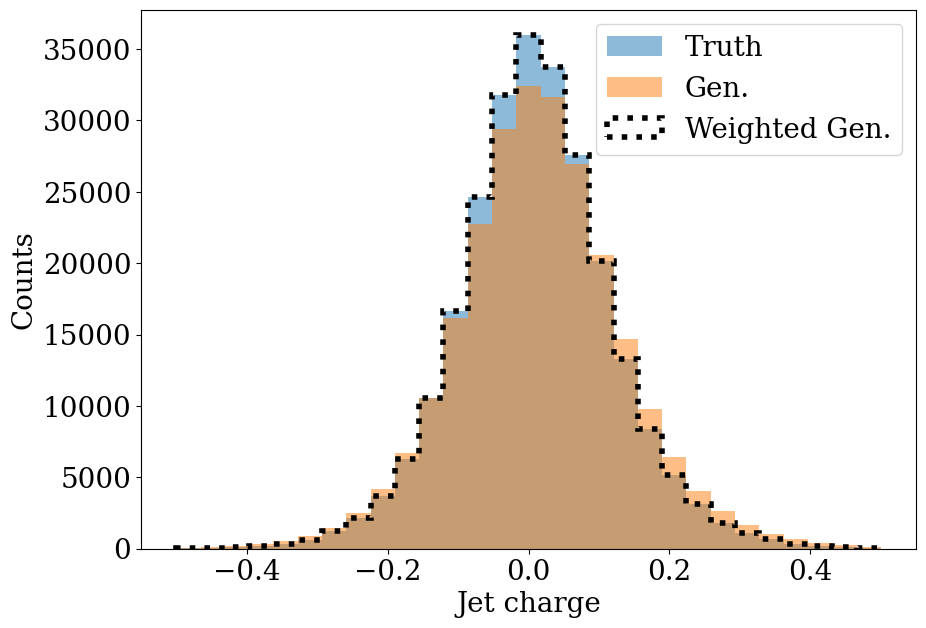

In [69]:
nbins = 30
b_min = -.5
b_max = .5

fig, ax = plt.subplots(figsize = (10, 7))

plt.hist(data_truth, alpha = 0.5, label = 'Truth', bins=np.linspace(b_min,b_max,nbins))
plt.hist(data_gen, alpha = 0.5, label = 'Gen.',bins=np.linspace(b_min,b_max,nbins)) 
plt.hist(X_test_particle[Y_test==1][:,0]*xs + xm, weights = w_test[Y_test==1], histtype="step", ls = ':',  color = 'black', lw = 4, label = 'Weighted Gen.', bins=np.linspace(b_min,b_max,nbins))
plt.legend()

plt.xlabel("Jet charge")
plt.ylabel("Counts")
plt.savefig(f"figures/{obs}pjetexample.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Set up binning

In [70]:
#For the binning, make it so we have 50% in each bin growing from the low side
binvals = [100]
i = 0
while binvals[-1] < 500:
    for binhigh in range(binvals[i]+1,1000):
        purity = len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)*(pT_reco > binvals[i])*(pT_reco < binhigh)]) / len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)])
        if (purity > 0.5**0.5):
            i+=1
            binvals+=[binhigh]
            break

In [71]:
features = {}

features["m","rec","nom"] = m_reco
features["m","tru","nom"] = m_true
features["m","rec","alt"] = m_reco_alt
features["m","tru","alt"] = m_true_alt

features["q","rec","nom"] = q_reco
features["q","tru","nom"] = q_true
features["q","rec","alt"] = q_reco_alt
features["q","tru","alt"] = q_true_alt

maxvalues = {}

maxvalues['m'] = 200
maxvalues['w'] = 0.7
maxvalues['q'] = 0.5
maxvalues['r'] = 1

minvalues = {}

minvalues['m'] = 0
minvalues['w'] = 0
minvalues['q'] = -0.5
minvalues['r'] = 0

In [72]:
binvalsObs = {}

binvalsObs[obs] = {}
pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1
xt = features[obs,"tru","nom"]
xr = features[obs,"rec","nom"]
for ii in range(len(binvals)-1):
    binvalsObs[obs][ii] = [minvalues[obs]]
    i = 0
    disttotal = 0.
    breakloop = True
    while len(binvalsObs[obs][ii]) < 15 and binvalsObs[obs][ii][-1] < maxvalues[obs] and breakloop:
        mycount = 0
        for binhigh in np.linspace(binvalsObs[obs][ii][i]+0.01,maxvalues[obs],100):
            mycount+=1
            purity = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xt[(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)]))
            distamount = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xr[(pTbin_reco==ii)*(pTbin_truth==ii)]))
            if (purity > 0.5):
                i+=1
                disttotal += distamount
                binvalsObs[obs][ii]+=[binhigh]
                #print("  ",binhigh,purity,disttotal,distamount)
                break
            if (mycount==99):
                breakloop = False
                #binvalsObs[obs][ii]+=[rmax]

    pass



In [73]:
#Next, let's construct the response matrix.

pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

xbin_truth_all = np.array([np.clip(np.digitize(xt,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
xbin_reco_all = np.array([np.clip(np.digitize(xr,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
xbin_truth_all = xbin_truth_all.T
xbin_reco_all = xbin_reco_all.T

xbin_truth = np.array([xbin_truth_all[i][pTbin_truth[i]] for i in range(len(pTbin_truth))])
xbin_reco = np.array([xbin_reco_all[i][pTbin_reco[i]] for i in range(len(pTbin_reco))])

###
bin2_truth = []
for i in range(len(pTbin_truth)):
    mybin = 0
    for i2 in range(0,pTbin_truth[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_truth+=[mybin+xbin_truth[i]]

bin2_reco = []
for i in range(len(pTbin_reco)):
    mybin = 0
    for i2 in range(0,pTbin_reco[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_reco+=[mybin+xbin_reco[i]]

#alt
xta = features[obs,"tru","alt"]
xra = features[obs,"rec","alt"]

pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

xbin_truth_all_alt = np.array([np.clip(np.digitize(xta,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
xbin_reco_all_alt = np.array([np.clip(np.digitize(xra,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
xbin_truth_all_alt = xbin_truth_all_alt.T
xbin_reco_all_alt = xbin_reco_all_alt.T

xbin_truth_alt = np.array([xbin_truth_all_alt[i][pTbin_truth_alt[i]] for i in range(len(pTbin_truth_alt))])
xbin_reco_alt = np.array([xbin_reco_all_alt[i][pTbin_reco_alt[i]] for i in range(len(pTbin_reco_alt))])

bin2_truth_alt = []
for i in range(len(pTbin_truth_alt)):
    mybin = 0
    for i2 in range(0,pTbin_truth_alt[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_truth_alt+=[mybin+xbin_truth_alt[i]]

bin2_reco_alt = []
for i in range(len(pTbin_reco_alt)):
    mybin = 0
    for i2 in range(0,pTbin_reco_alt[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_reco_alt+=[mybin+xbin_reco_alt[i]]

In [74]:
pTbin_truth_test = np.clip(np.digitize(X_test_particle[:,1]*ps + pm,binvals),1,len(binvals)-1)-1


In [80]:
pts = pTbin_truth_test[Y_test==1]
ptg = pTbin_truth_test[Y_test==0]

x1_wg = [np.average(data_gen[ptg==i],
                        weights = w_test[(Y_test==0)*(pTbin_truth_test==i)]) for i in range(len(binvals)-1)]

x1_t = [np.mean(data_truth[pts==i]) for i in range(len(binvals)-1)]

x1_g = [np.mean(data_gen[ptg==i]) for i in range(len(binvals)-1)]
                        
x2_wg = [np.average(data_gen[ptg==i]**2,
                        weights = w_test[(Y_test==0)*(pTbin_truth_test==i)]) for i in range(len(binvals)-1)]
                        
x2_t = [np.mean(data_truth[pts==i]**2) for i in range(len(binvals)-1)]
                        
x2_g = [np.mean(data_gen[ptg==i]**2) for i in range(len(binvals)-1)]


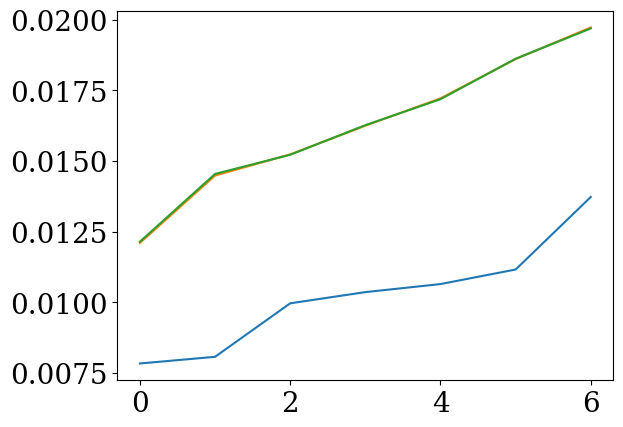

In [91]:
plt.plot(x1_t)
plt.plot(x1_g)
plt.plot(x1_wg)

In [81]:
np.savez('npfiles/moment_unfolding_q', x1_wg = x1_wg, x1_t = x1_t, x2_wg = x2_wg, x2_t = x2_t, x1_g = x1_g, x2_g = x2_g)

## Plotting, run from here

In [82]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

In [103]:
moment = 2
obs = 'm'

In [104]:
mom_unfold = np.load('npfiles/moment_unfolding_'+obs+'.npz')

In [105]:
truth = mom_unfold[f'x{moment}_t']
weighted_gen = mom_unfold[f'x{moment}_wg']
gen = mom_unfold[f'x{moment}_g']

In [106]:
binvals = np.array(binvals)
binmid = (binvals[:-1] + binvals[1:])/2

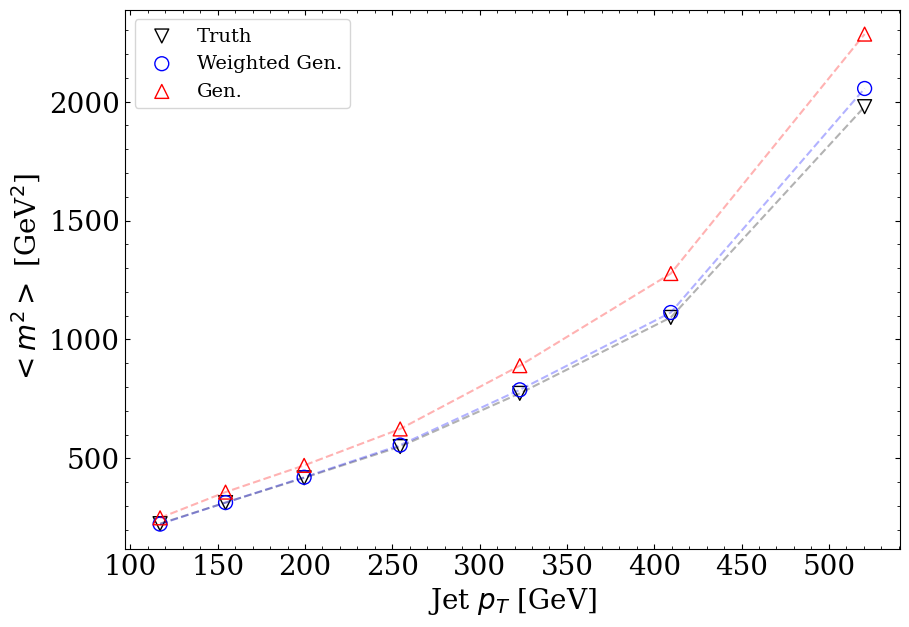

In [107]:
fig, ax0 = plt.subplots(figsize=(10, 7))
markersize = 100

ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')

ax0.tick_params(direction="in",which="both")
plt.yticks(fontsize=20)
ax0.minorticks_on()


ax0.scatter(binmid,truth,marker='v',label="Truth",edgecolors='black', facecolors='none', s = markersize)
ax0.plot(binmid,truth,ls = '--', c = 'black', alpha = 0.3)
ax0.scatter(binmid, weighted_gen, label="Weighted Gen.", marker = 'o', edgecolors = 'b', facecolors = 'none', s = markersize)
ax0.plot(binmid,weighted_gen,ls = '--', c = 'blue', alpha = 0.3)
ax0.scatter(binmid,gen,marker='^',label="Gen.",edgecolors='red', facecolors='none', s = markersize)
ax0.plot(binmid,gen,ls = '--', c = 'r', alpha = 0.3)


#plt.ylim([0.05,0.25])

plt.legend(frameon=True,fontsize=14)
if (moment==1):
    plt.ylabel(r'$< '+obs+' >$',fontsize=20)
else:
    plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$',fontsize=20)
if (obs=='m'):
    if (moment==1):
        plt.ylabel(r'$< '+obs+' >$ [GeV]',fontsize=20)
    else:
        plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$ [GeV$^'+str(moment)+'$]',fontsize=20)
    
ax0.set_xlabel("Jet $p_{T}$ [GeV]",fontsize=20)


fig.savefig('figures/pjetvar.pdf',bbox_inches='tight')
plt.show()